# Prototyping Notebook

Prototyping for data loading, retrievals and evals



In [ ]:

from dotenv import load_dotenv
import os
from uuid import uuid4

load_dotenv()

assert os.getenv("OPENAI_API_KEY"), "Missing OPENAI_API_KEY"
assert os.getenv("TAVILY_API_KEY"), "Missing TAVILY_API_KEY"
assert os.getenv("LANGCHAIN_API_KEY"), "Missing LANGCHAIN_API_KEY"
assert os.getenv("COHERE_API_KEY"), "Missing COHERE_API_KEY"

langsmith_api_key = os.getenv("LANGCHAIN_API_KEY")

os.environ["LANGCHAIN_TRACING_V2"] = "true"
langsmith_project_name = "AIM-CERT-LANGGRAPH-PARENT"
os.environ["LANGCHAIN_PROJECT"] = langsmith_project_name
print(langsmith_project_name)

MODE = "PIPE-ADV"

from langgraph_agent import LangGraphAgent, RetrievalEnums

Agent = LangGraphAgent(retriever_mode=RetrievalEnums.PARENT_DOCUMENT, 
                       MODE=MODE, 
                       langchain_project_name= langsmith_project_name)


AIM-CERT-LANGGRAPH-PARENT


# Load Eval Golden Dataset

In [2]:
from pathlib import Path
import pickle

with open(f"eval_golden_dataset.pkl", "rb") as f:
    golden_dataset = pickle.load(f)

# Evaluations

In [ ]:

import copy
import pickle
from langchain_openai import ChatOpenAI
from ragas.llms import LangchainLLMWrapper
from ragas import EvaluationDataset
from ragas import evaluate as evaluate_ragas, RunConfig
from ragas.metrics import (
    LLMContextPrecisionWithReference,
    LLMContextRecall,
    ContextEntityRecall,
    Faithfulness,
    ResponseRelevancy
    )
import numpy as np
import pickle
import prompts
import importlib
importlib.reload(prompts)

skip_evaluation = []

eval_full_results = {}
eval_summary_results = {}
eval_langsmith_raw_results = {}
eval_langsmith_summary_results = {}

# Prepare dataset for this chain
golden_dataset_active_copy = copy.deepcopy(golden_dataset)

count = 0
# Generate responses for evaluation
for test_row in golden_dataset_active_copy:

    print(f"user input: {test_row.eval_sample.user_input}")
    
    response = await Agent.chat(test_row.eval_sample.user_input + "Use your RAG tool or web search tool to get context to asnwer my question")
    
    Agent.reset_longer_term_memory()

    test_row.eval_sample.response = response["response"]

    count += 1
    for source in ["rag", "search"]:
        for context in response["context"].get(source, []):
            if hasattr(context, "page_content"):
                print(f"{count} - {source} - type: {type(context)}")
            else:
                print(f"{count} {source} - type: {type(context)}")
                     
    # Merge context from RAG and search
    test_row.eval_sample.retrieved_contexts = [
        context.page_content if hasattr(context, "page_content") else context
        for source in ["rag", "search"]
        for context in response["context"].get(source, [])
    ]

evaluation_active_dataset = EvaluationDataset.from_pandas(golden_dataset_active_copy.to_pandas())
evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-mini"))

custom_run_config = RunConfig(timeout=600)

# Run evaluation using only RETRIEVAL metrics
print("Running RAGAS evaluation...")
eval_result_active = evaluate_ragas(
    dataset=evaluation_active_dataset,
    metrics=[LLMContextPrecisionWithReference(), LLMContextRecall(), ContextEntityRecall(), Faithfulness(), ResponseRelevancy()],
    llm=evaluator_llm,
    run_config=custom_run_config
)

eval_full_resultsc= eval_result_active

# Convert to DataFrames and compute statistics
df_eval_result_active = eval_result_active.to_pandas()
eval_result_active_means = df_eval_result_active.mean(numeric_only=True)
eval_result_active_stds = df_eval_result_active.std(numeric_only=True)

eval_summary_results = {
    "means": eval_result_active_means,
    "stds": eval_result_active_stds
}

print(f"RAGAS Results for pipeline with baseline retrieval:")
print(eval_result_active_means)
print(eval_result_active_stds)

# save results to pickle in case of errors or crashes
pickle_agent_baseline_ragas_results = { 
    "raw_results": eval_result_active, 
    "summary_results": eval_summary_results }

# Save to file
with open(f"cert_agent_eval_ragas_results_for_baseline_retrieval.pkl", "wb") as f:
    pickle.dump(pickle_agent_baseline_ragas_results, f)


user input: How can parents help their child develop the executive function skills of the prefrontal cortex?
1 rag - type: <class 'str'>
user input: Howw can I help my child develup their prefrontal cortex?
2 rag - type: <class 'str'>
user input: Wut shud I do if my kid keeps forgeting the permision slip?
3 rag - type: <class 'str'>
user input: Why children under age ten not hear me when I talk, even if I say it loud?
4 rag - type: <class 'str'>
user input: How can using a hand puppet help encourage cooperation from an older child when preparing for a new sibling?
5 rag - type: <class 'str'>
user input: Why children need to learn about trust and how come it important for them to feel safe in the world, and what should I do about children seeing scary things on TV?
6 rag - type: <class 'str'>
user input: What I supposed to do when Isaac come home from religious school and say God want him to hurt someone, like in that Abraham and Isaac story?
7 rag - type: <class 'str'>
user input: How 

Evaluating:   0%|          | 0/255 [00:00<?, ?it/s]

Exception raised in Job[161]: AttributeError('StringIO' object has no attribute 'classifications')
Exception raised in Job[97]: TimeoutError()


RAGAS Results for pipeline with baseline retrieval:
llm_context_precision_with_reference    1.000000
context_recall                          0.893016
context_entity_recall                   0.269235
faithfulness                            0.897996
answer_relevancy                        0.913046
dtype: float64
llm_context_precision_with_reference    1.121270e-16
context_recall                          1.781571e-01
context_entity_recall                   3.477679e-01
faithfulness                            1.585123e-01
answer_relevancy                        1.882410e-01
dtype: float64


Visualizations

/tmp/ipykernel_304552/677595952.py:46: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


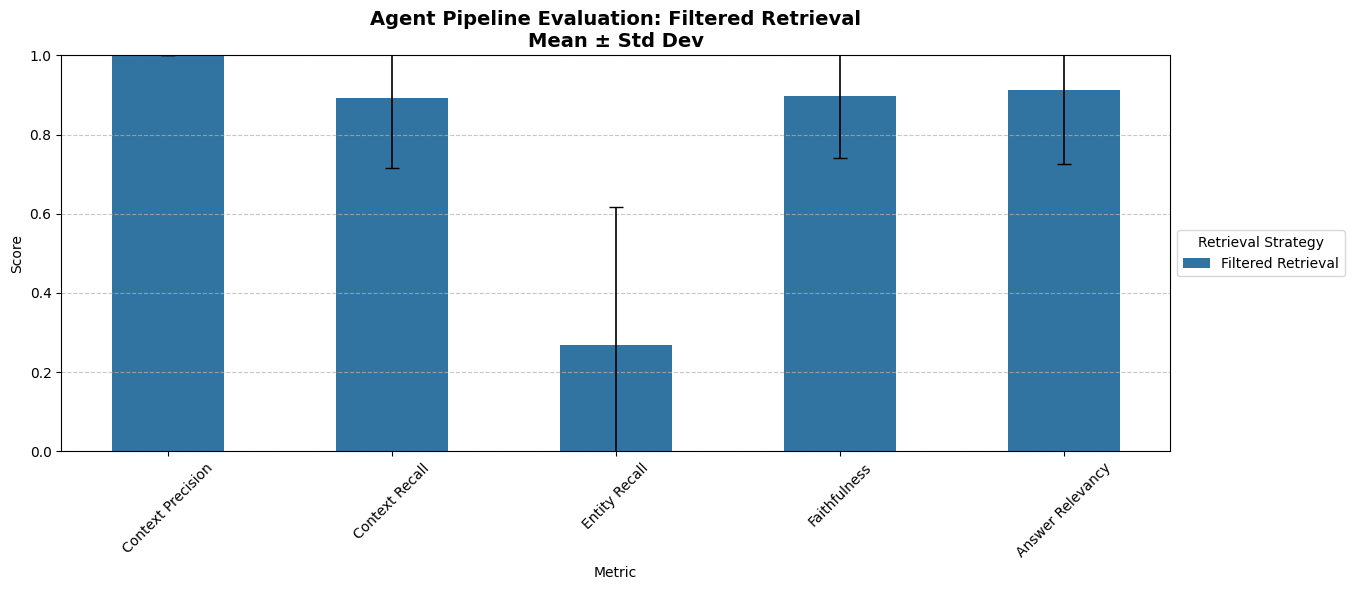

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def create_barplot_with_error(eval_summary_results, strategy_name="Baseline Naive"):
    """
    Create a bar plot showing evaluation metrics for a single strategy,
    with error bars representing standard deviation and legend outside the plot.
    """
    # Define metric keys and display labels
    metrics = [
        'llm_context_precision_with_reference',
        'context_recall',
        'context_entity_recall',
        'faithfulness',
        'answer_relevancy'
    ]
    metric_labels = [
        'Context Precision',
        'Context Recall',
        'Entity Recall',
        'Faithfulness',
        'Answer Relevancy'
    ]
    
    # Extract means and stds
    means = eval_summary_results["means"]
    stds = eval_summary_results["stds"]

    # Prepare data
    data = []
    for metric, label in zip(metrics, metric_labels):
        data.append({
            "Metric": label,
            "Mean": means[metric],
            "Std": stds[metric],
            "Strategy": strategy_name
        })

    # Create DataFrame
    df = pd.DataFrame(data)

    # Plot setup
    plt.figure(figsize=(14, 6))  # wider to accommodate external legend
    ax = plt.gca()
    sns.barplot(
        data=df,
        x="Metric",
        y="Mean",
        hue="Strategy",
        ax=ax,
        capsize=0.1,
        dodge=False,
        width=0.5,
        ci=None  # Manual error bars
    )

    # Manually centered error bars
    bar_container = ax.containers[0]
    for bar, row in zip(bar_container, df.itertuples()):
        x = bar.get_x() + bar.get_width() / 2
        ax.errorbar(
            x, row.Mean, yerr=row.Std,
            fmt='none', c='black', capsize=5, linewidth=1.2
        )

    # Final plot formatting
    plt.title(f'Agent Pipeline Evaluation: {strategy_name}\nMean ± Std Dev', fontsize=14, fontweight='bold')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # leave space on the right

    # Legend outside the plot area
    plt.legend(
        title="Retrieval Strategy",
        loc='center left',
        bbox_to_anchor=(1, 0.5),
        borderaxespad=0.5
    )

    plt.show()

    return df

# Example usage:
barplot_df = create_barplot_with_error(eval_summary_results, strategy_name="Filtered Retrieval")
